[Introduction]
팩터 투자 : 자산 배분, 퀀트 트레이딩, 자산관리 -> 를 포괄하는 어떤 큰 분야의 하위 분야
팩터투자의 전제 : 기업 수익률의 차이를 해당 기업의 특성으로 설명할 수 있음

[1.1 표기법]
인스턴스 = 레코드 = 관측치
속성 = 특성 = 입력 변수 = 예측 인자 -> 독립적 & 설명력 있는 변수들
f : 확률 밀도 함수
F : 누적 밀도 함수
X_t 와 X_s 분포 동일 : 정상성 -> 시간에 관계 없이 확률과정 동일
가우시안 분포 = 정규 분포
card()=#() : 인자로 받은 집합의 원소 개수 반환하는 기수 함수
s() : 소프트맥스 함수

# 1.2 데이터셋

In [2]:
# 데이터(.rdata) 불러오기
import pandas as pd
data_raw=pd.read_csv('data_ml.csv')

In [3]:
data_raw.iloc[0:3,0:3]

,stock_id,date,Advt_12M_Usd
0,13,2006-12-31,0.25
1,13,2007-01-31,0.25
2,13,2007-02-28,0.26


In [4]:
# 날짜 인덱스 생성
idx_date=data_raw.index[(data_raw['date']>'1999-12-31')&
                        (data_raw['date']<'2019-01-01')].tolist()
# 날짜 인덱스에 따라 데이터셋 필터링
data_ml=data_raw.iloc[idx_date]

In [5]:
# 데이터 프레임 보기
print(data_ml.columns)

Index(['stock_id', 'date', 'Advt_12M_Usd', 'Advt_3M_Usd', 'Advt_6M_Usd',
       'Asset_Turnover', 'Bb_Yld', 'Bv', 'Capex_Ps_Cf', 'Capex_Sales',
       'Cash_Div_Cf', 'Cash_Per_Share', 'Cf_Sales', 'Debtequity', 'Div_Yld',
       'Dps', 'Ebit_Bv', 'Ebit_Noa', 'Ebit_Oa', 'Ebit_Ta', 'Ebitda_Margin',
       'Eps', 'Eps_Basic', 'Eps_Basic_Gr', 'Eps_Contin_Oper', 'Eps_Dil', 'Ev',
       'Ev_Ebitda', 'Fa_Ci', 'Fcf', 'Fcf_Bv', 'Fcf_Ce', 'Fcf_Margin',
       'Fcf_Noa', 'Fcf_Oa', 'Fcf_Ta', 'Fcf_Tbv', 'Fcf_Toa', 'Fcf_Yld',
       'Free_Ps_Cf', 'Int_Rev', 'Interest_Expense', 'Mkt_Cap_12M_Usd',
       'Mkt_Cap_3M_Usd', 'Mkt_Cap_6M_Usd', 'Mom_11M_Usd', 'Mom_5M_Usd',
       'Mom_Sharp_11M_Usd', 'Mom_Sharp_5M_Usd', 'Nd_Ebitda', 'Net_Debt',
       'Net_Debt_Cf', 'Net_Margin', 'Netdebtyield', 'Ni', 'Ni_Avail_Margin',
       'Ni_Oa', 'Ni_Toa', 'Noa', 'Oa', 'Ocf', 'Ocf_Bv', 'Ocf_Ce', 'Ocf_Margin',
       'Ocf_Noa', 'Ocf_Oa', 'Ocf_Ta', 'Ocf_Tbv', 'Ocf_Toa', 'Op_Margin',
       'Op_Prt_Margin', 'Oper_Ps_Net_

R()M_Usd : ()개월  미래 수익률
수익률 = 총수익률 : 해당 기간 동안 잠재적 배당금 지급액 포함 (가격 등락 + 배당금)

Text(0, 0.5, 'nb_assets')

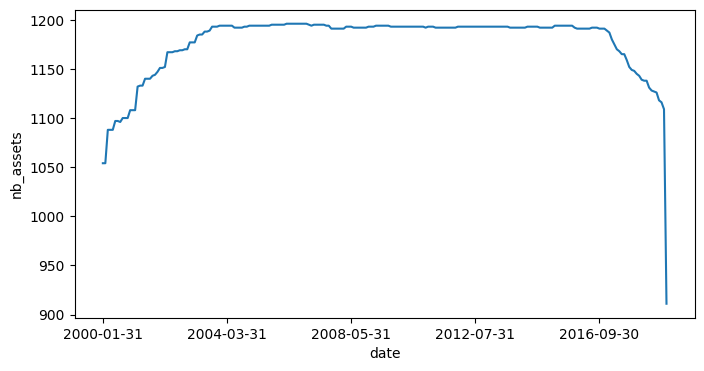

In [6]:
import matplotlib.pyplot as plt
# 각 날짜별 자산 개수 세기
pd.Series(data_ml.groupby('date').size()).plot(figsize=(8,4))
# y축 제목 추가 후 그래프 그리기
plt.ylabel('nb_assets')

In [7]:
# 향후 모델에 사용 위해 예측 인자들 이름 저장
features=list(data_ml.iloc[:,3:95].columns)
features_short=['Div_Yld','Eps','Mkt_Cap_12M_Usd',"Mom_11M_Usd",'Ocf','Pb','Vol1Y_Usd']

예측 인자들 : 균일화 되어있음 -> 어떤 특성과 시점에서든 분포가 균일함

Text(0, 0.5, 'count')

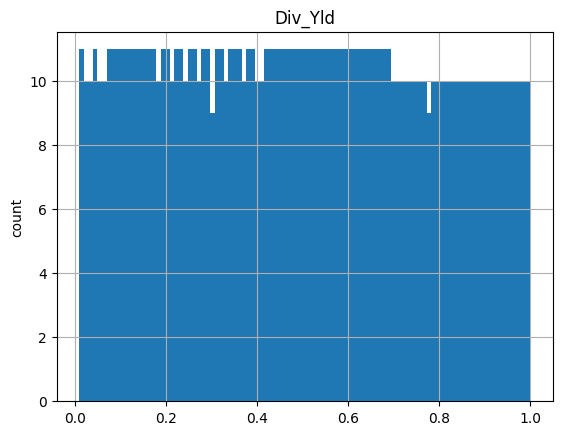

In [8]:
# 특성 Div_Yld 열의 위치 찾기
col_feat_Div_Yld=data_ml.columns.get_loc('Div_Yld')
# 필터링할 부울 인덱스 생성
is_custom_date=data_ml['date']=='2000-02-29'
# 히스토그램
data_ml[is_custom_date].iloc[:,[col_feat_Div_Yld]].hist(bins=100)
plt.ylabel('count')
# -> 2000.02.29 배당 수익률 특성의 분포

In [9]:
df_median=[]
df=[]
import numpy as np
# 각 날짜별 중간값 계산
df_median=data_ml[['date','R1M_Usd','R12M_Usd']].groupby(
    ['date']).median()
df_median.rename(
    columns={"R1M_Usd":"R1M_Usd_median",
             "R12M_Usd":"R12M_Usd_median"},inplace=True
)

In [10]:
# 데이터 프레임 합치기
df=pd.merge(data_ml,df_median,how='left',on=['date'])
# np.where(조건, 참일 때 값, 거짓일 때 값)
data_ml['R1M_Usd_C']=np.where(df['R1M_Usd']>df['R1M_Usd_median'],1.0,0.0)
data_ml['R12M_Usd_C']=np.where(df['R12M_Usd']>df['R12M_Usd_median'],1.0,0.0)

C:\Users\82103\AppData\Local\Temp\ipykernel_7260\960734806.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_ml['R1M_Usd_C']=np.where(df['R1M_Usd']>df['R1M_Usd_median'],1.0,0.0)
C:\Users\82103\AppData\Local\Temp\ipykernel_7260\960734806.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_ml['R12M_Usd_C']=np.where(df['R12M_Usd']>df['R12M_Usd_median'],1.0,0.0)


In [11]:
# 머신러닝 데이터셋 분리
separation_date='2014-01-15'
idx_train=data_ml.index[(data_ml['date']<separation_date)].tolist()
idx_test=data_ml.index[(data_ml['date']>=separation_date)].tolist()

In [12]:
# 자산 식별 코드 및 수익률 df 등 주요 변수를 따로 메모리에 보관
stock_idx_short=[]
stock_days=[]
stock_ids=data_ml['stock_id'].unique()
# 각 주식별 데이터 포인트 개수 세기
stock_days=data_ml[['date','stock_id']].groupby(['stock_id']).count().reset_index()
# 데이터 포인트가 최대로 있는 종목만 유지
stock_ids_short=stock_days.loc[
    stock_days['date']==(stock_days['date'].max())
]
stock_ids_short=stock_ids_short['stock_id'].unique()
# 리스트로 변환
is_stock_ids_short=data_ml['stock_id'].isin(stock_ids_short)
# 주요 종목들의 수익률 행렬
returns=data_ml[is_stock_ids_short].pivot(index='date',columns='stock_id',values='R1M_Usd')
